In [1]:
import os, mea
import numpy as np
from utilsEphys import *
from reactivation import *
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
%matplotlib notebook 

In [2]:
# init data
dirname = r'/media/rajat/mcnlab_store2/Research/SPrecordings/Rajat_Data/Data-BackwardExpansion/SWIL14'
binwidth = 0.1 # 100 ms time bins
preRest = [0,600] # 10min pre-task
awake = [605,2425] #30mins awake task data
postRest = [2430,16800] #4hrs post-task

In [3]:
# load spike timestamps and cluster ids
spiketimes = np.load(os.path.join(dirname,'HCspikesorted','spiketimes.npy'), allow_pickle='True')
cluid = np.load(os.path.join(dirname,'HCspikesorted','spikeClusterID.npy'), allow_pickle='True')
Q = []
bins = np.arange(0,16800,binwidth)
for spk in spiketimes:
    Q.append(np.histogram(spk, bins)[0])
Q = np.array(Q)
Qpre = Q[:,(bins[:-1]>=preRest[0]) & (bins[:-1]<=preRest[-1])]
Qtask = Q[:,(bins[:-1]>=awake[0]) & (bins[:-1]<=awake[-1])]
Qpost = Q[:,(bins[:-1]>=postRest[0]) & (bins[:-1]<=postRest[-1])]
print(Qpre.shape, Qtask.shape, Qpost.shape)

(174, 6001) (174, 18201) (174, 143699)


<IPython.core.display.Javascript object>


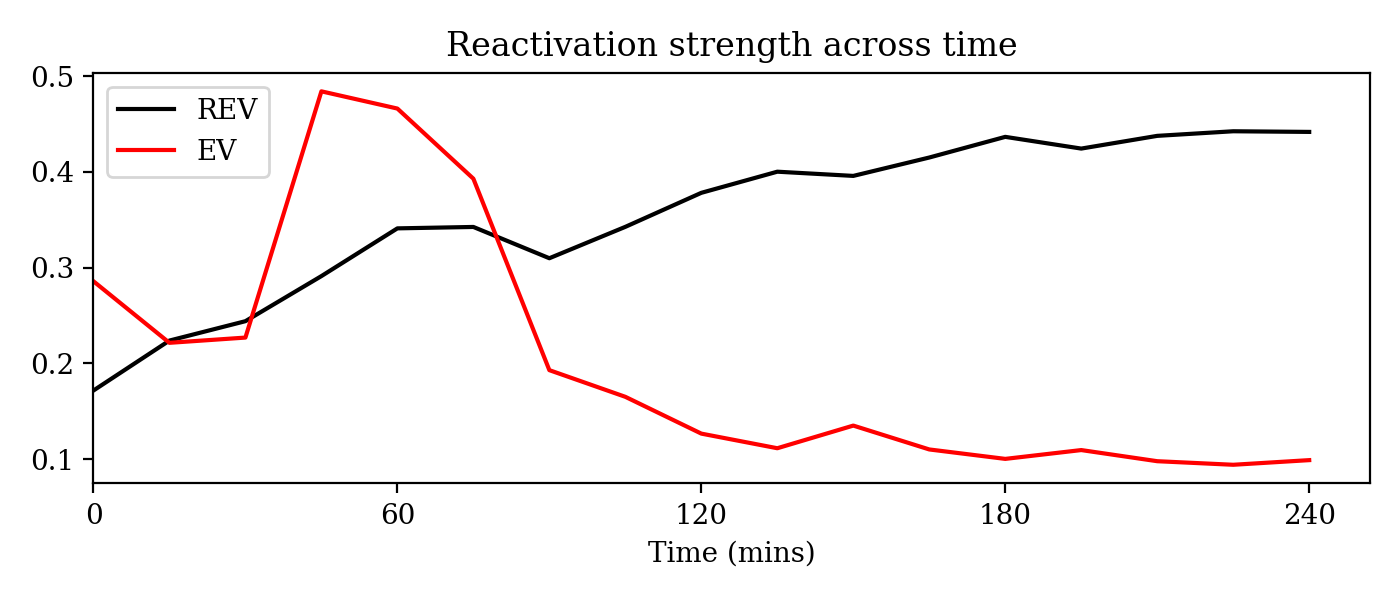

In [4]:
# 1. reactivation strength in 30mins block post task rest
rev = []
ev = []
for i in range(17):
    size = Qpre.shape[1]+1
    e, re = calcEV(Qpre, Qtask, Qpost[:,i*size:(i+1)*size])
    ev.append(e)
    rev.append(re)
rev = np.array(rev)
ev = np.array(ev)

# plot the explained variance across time
plt.figure(figsize=(7,3))
plt.plot(np.arange(len(rev)), rev, 'k')
plt.plot(np.arange(len(rev)), ev, 'r')
plt.legend(['REV', 'EV'])
plt.xticks(np.arange(0,len(ev),4), np.arange(0,len(ev),4)*15)
plt.xlim([0,None])
plt.xlabel('Time (mins)')
plt.title('Reactivation strength across time')
plt.tight_layout()
plt.show()

# Reactivation using PCA

In [5]:
# only include cells with active neurons across all three epochs
idx = (np.nansum(Qpre,1)>0) & ((np.nansum(Qtask,1)>0)) & ((np.nansum(Qpost,1)>0))
Qpre = Qpre[idx,:]
Qtask = Qtask[idx,:]
Qpost = Qpost[idx,:]

(6001, 173) (173, 173) (6001, 16)
(143699, 173) (173, 173) (143699, 16)


<IPython.core.display.Javascript object>


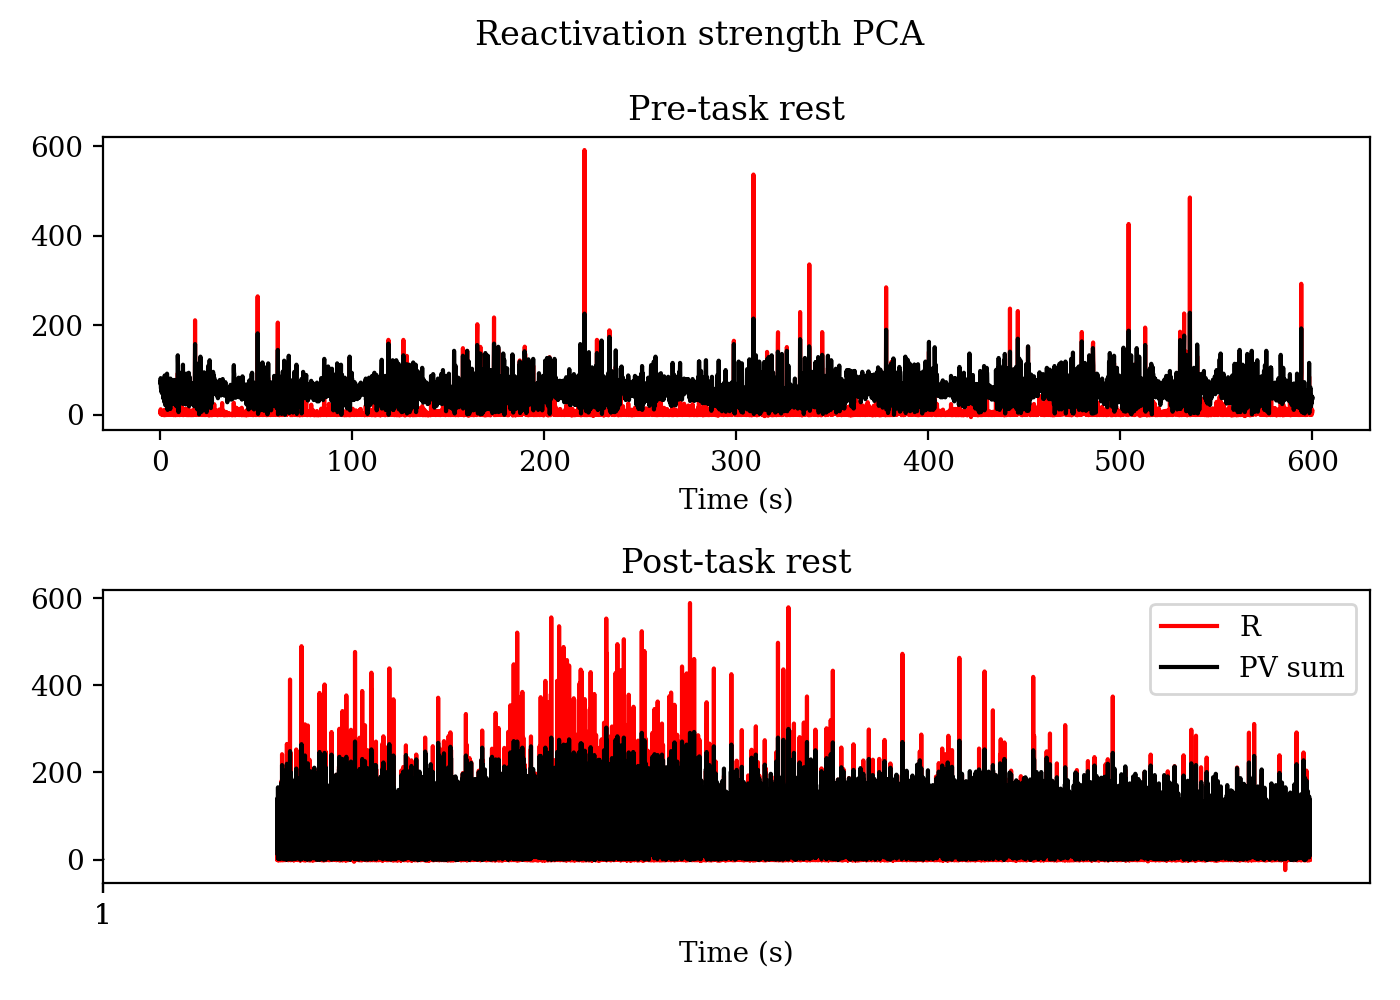

In [6]:
# 2. calculate reactivation strength using PCA for diff. task epochs
Rpretask, _ = calcReactStrength(Qtask, Qpre)
Rposttask, _ = calcReactStrength(Qtask, Qpost)

# plot reactivation strength of first PC
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,5))
ax[0].plot(np.linspace(preRest[0],preRest[-1],Rpretask.shape[0]), Rpretask[:,0],c='r')
ax[0].plot(np.linspace(preRest[0],preRest[-1],Qpre.shape[1]),np.nansum(Qpre,0),c='k')
ax[0].set_title('Pre-task rest')
ax[0].set_xlabel('Time (s)')
ax[1].plot(np.linspace(postRest[0],postRest[-1],Rposttask.shape[0]), Rposttask[:,0],c='r')
ax[1].plot(np.linspace(postRest[0],postRest[-1],Qpost.shape[1]),np.nansum(Qpost,0),c='k')
ax[1].set_title('Post-task rest')
ax[1].set_xlabel('Time (s)')
plt.legend(['R', 'PV sum'])
plt.suptitle('Reactivation strength PCA')
plt.tight_layout()
plt.show()